In [1]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.optim as optim
import imageio


# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

In [2]:
import matplotlib
%matplotlib qt5

from pylab import show, ginput, rand, imshow, plot, imread
from matplotlib.figure import Figure
import numpy as np

from scipy.spatial import Delaunay
import matplotlib.pyplot as plt

import numpy as np
import matplotlib.pyplot as plt
import skimage.io as skio
import os
from pylab import plot, ginput, show, axis
from scipy.spatial import Delaunay
from skimage.draw import polygon

## Helper functions

In [3]:
INPUT_PATH = "./data/"
OUTPUT_PATH = "output/"

%matplotlib inline
def display_image(image, display=True, addIntDisplay=False):
    if display and addIntDisplay:
        display_image_with_int(image)
    if display:
        imshow(image)
        plt.show()

def display_image_with_int(image):
    imshow(image.astype(np.uint8))
    plt.show()

def display_coords(im, points):
    x = points[1]
    y = points[0]
    plt.imshow(im.astype(np.uint8))
    plt.scatter(x,y,s=10,c='b')
    plt.draw()
    plt.show()

def display_points(im, points):
    x = []
    y = []
    for p in points:
        x.append(p[0])
        y.append(p[1])
    
    plt.imshow(im.astype(np.uint8))
    plt.scatter(x,y,s=10,c='r')
    plt.draw()
    plt.show()
    
def read_image(im_name, depth=True, display=False, addIntDisplay=False, saveAs='', input_path=INPUT_PATH):
    if depth:
        im = skio.imread(input_path + im_name)/1.
    else:
        im = skio.imread(input_path + im_name, 2)/1.
    display_image(im, display, addIntDisplay)
    save_image(im, saveAs)
    return im 

def save_image(image, file_to='', output_path="output/"):
    if file_to:
        imageio.imwrite(output_path + file_to, image)

import skimage.io as skio

def pick_points(image, addIntDisplay=False, already_saved_at='', saveAs='', num_pts=58):
    if already_saved_at and os.path.isfile("data/" + already_saved_at): 
        return np.loadtxt("data/" + already_saved_at) 
    else:
        if(addIntDisplay):
            imshow(image.astype(np.uint8))
        else:
            imshow(image)
        pts = np.array(ginput(num_pts, timeout=600))
        if already_saved_at: 
            np.savetxt("data/" + already_saved_at, pts)
        elif saveAs: 
            np.savetxt("data/" + saveAs, pts)
        return pts

##Taken from stackoverflow post
def rgb2gray(rgb):
    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
    return gray


## Step 1: Shoot the Pictures

In [4]:
oak1 = read_image("oak1.jpg", display=False, addIntDisplay=True)
oak2 = read_image("oak2.jpg",display=False, addIntDisplay=True)
oak3 = read_image("oak3.jpg",display=False, addIntDisplay=True)

ny1 = read_image("ny1.jpg",display=False, addIntDisplay=True)
ny2 = read_image("ny2.jpg",display=False, addIntDisplay=True)
ny3 = read_image("ny3.jpg",display=False, addIntDisplay=True)

room1 = read_image("room1.jpg",display=False, addIntDisplay=True)
room2 = read_image("room2.jpg",display=False, addIntDisplay=True)
room3 = read_image("room3.jpg",display=False, addIntDisplay=True)

kitchen1 = read_image("kitchen1.jpg",display=False, addIntDisplay=True)
kitchen2 = read_image("kitchen2.jpg",display=False, addIntDisplay=True)

book1 = read_image("book1.jpg",display=False, addIntDisplay=True)
book2 = read_image("book2.jpg",display=False, addIntDisplay=True)

house1 = read_image("house1.jpg",display=False, addIntDisplay=True)
house2 = read_image("house2.jpg",display=False, addIntDisplay=True)


## Step 2: Recover Homographies

In [5]:
import matplotlib
%matplotlib qt5
# %matplotlib inline
oak1_pts = pick_points(oak1, addIntDisplay=True, num_pts=12, already_saved_at='oak1.txt')


In [6]:
oak2_pts = pick_points(oak2, addIntDisplay=True, num_pts=12, already_saved_at='oak2.txt')


In [7]:
ny1_pts = pick_points(ny1, addIntDisplay=True, num_pts=12, already_saved_at='ny1.txt')


In [24]:
ny3_pts = pick_points(ny2, addIntDisplay=True, num_pts=12, already_saved_at='ny3.txt')


In [9]:
room1_pts = pick_points(room1, addIntDisplay=True, num_pts=12, already_saved_at='room1.txt')


In [10]:
room2_pts = pick_points(room2, addIntDisplay=True, num_pts=12, already_saved_at='room2.txt')


In [5]:
kitchen1_pts = pick_points(kitchen1, addIntDisplay=True, num_pts=10, already_saved_at='kitchen1.txt')


In [6]:
kitchen2_pts = pick_points(kitchen2, addIntDisplay=True, num_pts=10, already_saved_at='kitchen2.txt')


In [7]:
book1_pts = pick_points(book1, addIntDisplay=True, num_pts=10, already_saved_at='book1.txt')


In [8]:
book2_pts = pick_points(book2, addIntDisplay=True, num_pts=10, already_saved_at='book2.txt')


In [9]:
def computeA(source_pts, dest_pts):
    n = len(source_pts)
    counter = 0
    matrix = np.empty([2*n, 9])
    for i in np.arange(len(source_pts)):
        x = source_pts[i][0]
        y = source_pts[i][1]
        
        source_neg_x = -1*x
        source_neg_y = -1*y
        
        dest_neg_x = dest_pts[i][0]
        dest_neg_y = dest_pts[i][1]
        
        neg_x_x = source_neg_x*dest_neg_x
        neg_x_y_one = source_neg_y*dest_neg_x
        neg_x_y_two = source_neg_x*dest_neg_y
        neg_y_y = source_neg_y*dest_neg_y

        top = [x, y, 1, 0, 0, 0, neg_x_x, neg_x_y_one, -1*dest_neg_x]
        bottom = [0, 0, 0, x, y, 1, neg_x_y_two, neg_y_y, -1*dest_neg_y]
        
        matrix[counter] = top
        counter = counter + 1
        matrix[counter] = bottom
        counter = counter + 1

    return matrix

In [10]:
def computeHomographies(source_pts, dest_pts, dest_pts_flat):
    A = computeA(source_pts, dest_pts)
    U, S, VH = np.linalg.svd(A)
    VH = VH.T
    H = VH[:,8]
    H = np.reshape(H,[3,3])
    return H

In [11]:
## Adds 1 to each point in the picked points
def transform_pts(pts):
    counter = 0
    new_pts = np.empty([len(pts), 3], int)
    for x in pts:
        arr = [x[0], x[1], 1]
        new_pts[counter] = arr
        counter = counter + 1
    return new_pts

In [12]:
transf_oak1_pts = transform_pts(oak1_pts)

transf_oak2_pts = transform_pts(oak2_pts)

H_oak_matrix = computeHomographies(oak1_pts, oak2_pts, oak2_pts.flatten())

result = (H_oak_matrix@transf_oak1_pts.T)
result = result.T


NameError: name 'oak1_pts' is not defined

In [13]:
def divide_third(result):
    matrix = np.empty(result.shape)
    counter = 0
    for x in result:
        arr = x/(x[2])
        matrix[counter] = arr
        counter = counter + 1
    return matrix

In [20]:
predict_oak_pts = divide_third(result)
predict_oak_pts


array([[3.65917230e+03, 2.77912888e+03, 1.00000000e+00],
       [3.53016856e+03, 1.67192312e+03, 1.00000000e+00],
       [3.33104184e+03, 3.87844989e+02, 1.00000000e+00],
       [2.14988987e+03, 4.19892873e+02, 1.00000000e+00],
       [1.39780088e+03, 4.43325396e+02, 1.00000000e+00],
       [1.19910163e+03, 1.26232515e+03, 1.00000000e+00],
       [7.31349103e+02, 1.22211993e+03, 1.00000000e+00],
       [7.11576802e+02, 2.20812443e+03, 1.00000000e+00],
       [8.75022831e+02, 2.22186261e+03, 1.00000000e+00],
       [1.00737812e+03, 2.21632121e+03, 1.00000000e+00],
       [1.09106747e+03, 2.70250557e+03, 1.00000000e+00],
       [2.63398033e+03, 2.97086330e+03, 1.00000000e+00]])

In [21]:
transf_oak2_pts


array([[3741, 2875,    1],
       [3482, 1616,    1],
       [3352,  457,    1],
       [2200,  434,    1],
       [1376,  396,    1],
       [1201, 1235,    1],
       [ 629, 1197,    1],
       [ 713, 2211,    1],
       [ 911, 2219,    1],
       [1048, 2234,    1],
       [1117, 2753,    1],
       [2513, 2852,    1]])

In [25]:
transf_ny1_pts = transform_pts(ny1_pts)

transf_ny3_pts = transform_pts(ny3_pts)

H_ny_matrix = computeHomographies(ny1_pts, ny3_pts, ny3_pts.flatten().T)

result_two = (H_ny_matrix@transf_ny1_pts.T)
result_two = result_two.T

In [ ]:
predict_ny_pts = divide_third(result_two)
predict_ny_pts

array([[ 2.93406613e+02,  1.00811670e+03,  1.00000000e+00],
       [ 1.59859732e+03,  9.46029620e+02,  1.00000000e+00],
       [ 1.73653133e+03,  7.31842205e+02,  1.00000000e+00],
       [ 2.63232555e+03,  3.95824185e+02,  1.00000000e+00],
       [ 2.57987963e+03,  7.14763517e+02,  1.00000000e+00],
       [ 3.34619313e+03,  5.33588850e+02,  1.00000000e+00],
       [ 7.81211595e+02,  1.49007488e+03,  1.00000000e+00],
       [ 5.80864244e+02,  1.75085065e+03,  1.00000000e+00],
       [ 1.61889116e+03,  1.35302240e+03,  1.00000000e+00],
       [ 2.05507365e+03,  1.36774451e+03,  1.00000000e+00],
       [-1.30328836e+04, -4.74901693e+03,  1.00000000e+00],
       [ 3.30014894e+03,  1.12795786e+03,  1.00000000e+00]])

In [20]:
transf_ny3_pts

array([[ 198, 1015,    1],
       [1255,  620,    1],
       [1730,  889,    1],
       [2286,  898,    1],
       [2770,  603,    1],
       [3388,  603,    1],
       [3245, 1301,    1],
       [2716, 1203,    1],
       [2232, 1436,    1],
       [1766, 1427,    1],
       [1318, 1212,    1],
       [ 359, 1723,    1]])

In [17]:
transf_room1_pts = transform_pts(room1_pts)

transf_room2_pts = transform_pts(room2_pts)

H_room_matrix = computeHomographies(room1_pts, room2_pts, room2_pts.flatten().T)

result_three = (H_room_matrix@transf_room1_pts.T)
result_three = result_three.T

predict_room_pts = divide_third(result_three)


## Step 3: Warping

In [15]:
 def update_min_max(x_coord, y_coord, H, minwidth, maxwidth, minheight, maxheight):
    
    if x_coord < minwidth:
        minwidth = int(x_coord)
    if x_coord > maxwidth:
        maxwidth = int(x_coord)
    
    if y_coord < minheight:
        minheight = int(y_coord)
    if y_coord > maxheight:
        maxheight = int(y_coord)
    
    return minwidth, maxwidth, minheight, maxheight

In [16]:
""" 
    This function takes in the source image, the destination image and the homography matrix.
    It computes the bounding box, which includes the max/min width and max/min height for the warped image.
""" 
def create_bounding_box(source, dest, H):
    
    minwidth = float("inf")
    maxwidth = float("-inf")
    
    minheight = float("inf")
    maxheight = float("-inf")
    
    x, y, w = np.dot(H, [0 , 0, 1])
    minwidth, maxwidth, minheight, maxheight = update_min_max(x/w,y/w, H, minwidth, maxwidth, minheight, maxheight)
    
    x, y, w = np.dot(H, [source.shape[1] , source.shape[0], 1])
    minwidth, maxwidth, minheight, maxheight = update_min_max(x/w,y/w, H, minwidth, maxwidth, minheight, maxheight)
    
    x, y, w = np.dot(H, [0 , source.shape[1], 1])
    minwidth, maxwidth, minheight, maxheight = update_min_max(x/w,y/w, H, minwidth, maxwidth, minheight, maxheight)
    
    x, y, w = np.dot(H, [source.shape[0] , 0, 1])
    minwidth, maxwidth, minheight, maxheight = update_min_max(x/w,y/w, H, minwidth, maxwidth, minheight, maxheight)
    
    return minwidth, maxwidth, minheight, maxheight

In [17]:
def populate_dummy(source, dest, dummy_image, H_inv, minwidth, maxwidth, minheight, maxheight):
    for w in range(minwidth, maxwidth):
        for h in range (minheight, maxheight):
            x_coord, y_coord, weight = np.dot(H_inv, [w, h, 1])
            x_coord = int(x_coord/weight)
            y_coord = int(y_coord/weight)
            r = 0
            b = 0
            g = 0
            y_out_of_bounds = (y_coord < 0 or y_coord >= source.shape[0])
            x_out_of_bounds = (x_coord < 0 or x_coord >= source.shape[1])
            #if it's in bounds
            if not (y_out_of_bounds or x_out_of_bounds):
                r, b, g = source[y_coord, x_coord, :]
            dummy_image[h - minheight, w - minwidth, :] = [r/255, b/255, g/255]
            
    return dummy_image


In [18]:
def warpImage(source, dest, H):
    H_inv = np.linalg.inv(H) 
    
    #Create bounding box for the dummy image
    minwidth, maxwidth, minheight, maxheight = create_bounding_box(source, dest, H)
    
    #These are the dimensions for the warped image
    warped_height = maxheight - minheight
    warped_width = maxwidth - minwidth
    
    #Create dummy image to populate the warped coordinates
    dummy_image = np.zeros((warped_height, warped_width, 3))
    
    dummy_image = populate_dummy(source, dest, dummy_image, H_inv, minwidth, maxwidth, minheight, maxheight)
    
    return minwidth, maxwidth, minheight, maxheight, dummy_image
    

In [25]:
%matplotlib inline

oakminwidth, oakmaxwidth, oakminheight, oakmaxheight, oak_dummy_image = warpImage(oak1, oak2, H_oak_matrix)

save_image(oak_dummy_image, "oakland_warped_image.jpg")

plt.imshow(oak_dummy_image)
plt.show()


KeyboardInterrupt: 

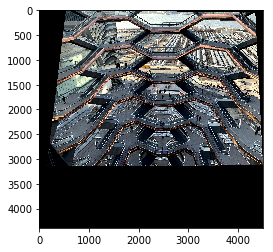

In [29]:
%matplotlib inline

nyminwidth, nymaxwidth, nyminheight, nymaxheight, ny_dummy_image = warpImage(ny1, ny3, H_ny_matrix)

save_image(ny_dummy_image, "ny_warped_image.jpg")

plt.imshow(ny_dummy_image)
plt.show()


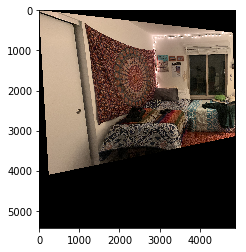

In [24]:
%matplotlib inline

roomminwidth, roommaxwidth, roomminheight, roommaxheight, room_dummy_image = warpImage(room1, room2, H_room_matrix)

save_image(room_dummy_image, "room_warped_image.jpg")

plt.imshow(room_dummy_image)
plt.show()


## Step 4: Image Rectification



In [25]:
import matplotlib
%matplotlib qt5
# %matplotlib inline
oakrectsource_pts = pick_points(oak2, addIntDisplay=True, num_pts=4, already_saved_at='oakrectsource.txt')


In [26]:
import matplotlib
%matplotlib qt5
oakrect1source_pts = pick_points(oak1, addIntDisplay=False, num_pts=4, already_saved_at='oakrect1source.txt')


In [27]:
oakrectdest_pts = pick_points(oak1, addIntDisplay=True, num_pts=4, already_saved_at='oakrectdest.txt')



In [28]:
oakrectdest_pts

array([[  7.28807947,   5.6192053 ],
       [438.41390728,  19.52649007],
       [438.41390728, 603.63245033],
       [  8.26445526, 604.65934267]])

In [29]:
oakrectdest_pts[0][0] = 0
oakrectdest_pts[0][1] = 0

oakrectdest_pts[1][0] = 434
oakrectdest_pts[1][1] = 0

oakrectdest_pts[2][0] = 434
oakrectdest_pts[2][1] = 600

oakrectdest_pts[3][0] = 0
oakrectdest_pts[3][1] = 600

In [30]:
oakrectdest_pts

array([[  0.,   0.],
       [434.,   0.],
       [434., 600.],
       [  0., 600.]])

In [31]:
oakrect1source_pts

array([[2603.65171583, 1207.96718844],
       [3038.57043949, 1298.99668874],
       [3068.91360626, 1814.83052378],
       [2593.53732691, 1754.14419025]])

In [32]:
transf_oakrectsource = transform_pts(oakrect1source_pts)

transf_oakrectdest = transform_pts(oakrectdest_pts)

H_rect_matrix = computeHomographies(oakrect1source_pts, oakrectdest_pts, oakrectdest_pts.flatten())

result_three = (H_rect_matrix@transf_oakrectsource.T)
result_three = result_three.T

predict_rect_pts = divide_third(result_three)
predict_rect_pts

array([[-6.22491168e-01, -9.98579786e-01,  1.00000000e+00],
       [ 4.33446998e+02, -1.12764982e+00,  1.00000000e+00],
       [ 4.33143966e+02,  5.99233409e+02,  1.00000000e+00],
       [-4.56988011e-01,  5.99924574e+02,  1.00000000e+00]])

In [33]:
H_rect_matrix

array([[-3.62002688e-04, -6.70375354e-06,  9.50626835e-01],
       [ 9.79672057e-05, -4.68065538e-04,  3.10335329e-01],
       [ 7.24699908e-08, -6.87745288e-08, -4.95042371e-04]])

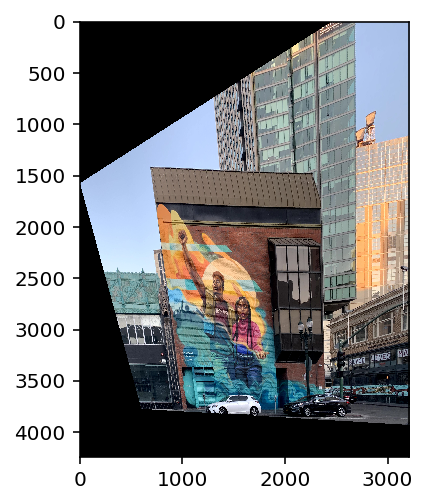

In [613]:
rectminwidth, rectmaxwidth, rectminheight, rectmaxheight, rect_img = warpImage(oak1, transf_oakrectdest, H_rect_matrix)

plt.imshow(rect_img)
plt.show()


## Step 5: Blend the images into a mosaic



In [19]:
def blend_images(source, dest, H, minwidth, maxwidth, minheight, maxheight, warped_image): 
    destminwidth = minwidth
    destmaxwidth = maxwidth
    
    destminheight = minheight
    destmaxheight = maxheight
    
    minwidth, maxwidth, minheight, maxheight = update_min_max(0,0, H, minwidth, maxwidth, minheight, maxheight)
    
    minwidth, maxwidth, minheight, maxheight = update_min_max(source.shape[1],source.shape[0], H, minwidth, maxwidth, minheight, maxheight)
    
    minwidth, maxwidth, minheight, maxheight = update_min_max(0,source.shape[1], H, minwidth, maxwidth, minheight, maxheight)
    
    minwidth, maxwidth, minheight, maxheight = update_min_max(source.shape[0],0, H, minwidth, maxwidth, minheight, maxheight)
    
    blended_image = np.zeros(((maxheight - minheight),(maxwidth - minwidth), 3))
    for w in range(minwidth, maxwidth):
        for h in range (minheight, maxheight):
            r = 0
            b = 0
            g = 0
            
            in_bounds_height_dest = (h > destminheight and h < destmaxheight)
            in_bounds_width_dest = (w > destminwidth and w < destmaxwidth)
            
            out_bounds_height_source = (h < 0 or h >= dest.shape[0])
            out_bounds_width_source = (w < 0 or w >= dest.shape[1])
            
            if in_bounds_height_dest and in_bounds_width_dest:
                r, b, g = warped_image[h - destminheight, w - destminwidth, :]
                if r == 0.0 or b == 0.0 or g == 0.0:
                    if not (out_bounds_height_source or out_bounds_width_source):
                        r, b, g = dest[h, w, :]/255
            else:
                if not (out_bounds_height_source or out_bounds_width_source):
                    r, b, g = dest[h, w, :]/255
            blended_image[h - minheight, w - minwidth, :] = [r, b, g]
    return blended_image


In [35]:
blended_oak = blend_images(oak1, oak2, H_oak_matrix, oakminwidth, oakmaxwidth, oakminheight, oakmaxheight, oak_dummy_image)



NameError: name 'oakminwidth' is not defined

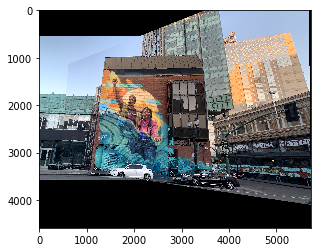

In [136]:
%matplotlib inline

save_image(blended_oak, "blended_oak_image.jpg")

plt.imshow(blended_oak)
plt.show()

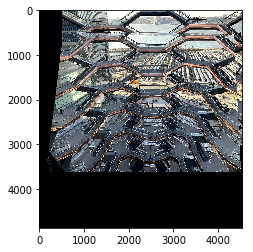

In [143]:
blended_ny = blend_images(ny1, ny2, H_ny_matrix, nyminwidth, nymaxwidth, nyminheight, nymaxheight, ny_dummy_image)

%matplotlib inline

save_image(blended_ny, "blended_ny_image.jpg")

plt.imshow(blended_ny)
plt.show()


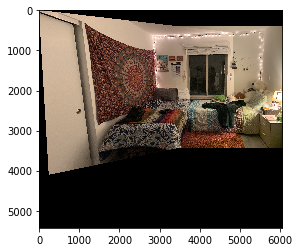

In [26]:
%matplotlib inline

blended_room = blend_images(room1, room2, H_room_matrix, roomminwidth, roommaxwidth, roomminheight, roommaxheight, room_dummy_image)

save_image(blended_room, "blended_room.jpg")

plt.imshow(blended_room)
plt.show()

In [27]:
save_image(blended_room, "blended_room.jpg")


done with homography
done with warping


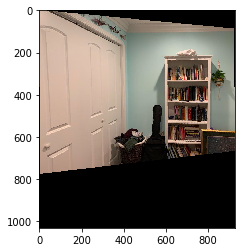

done with blending
done with saving


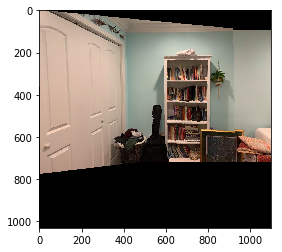

In [20]:
transf_book1_pts = transform_pts(book1_pts)

transf_book2_pts = transform_pts(book2_pts)

H_book_matrix = computeHomographies(book1_pts, book2_pts, book2_pts.flatten().T)
print("done with homography")
bminwidth, bmaxwidth, bminheight, bmaxheight, book_dummy_image = warpImage(book1, book2, H_book_matrix)
print("done with warping")
plt.imshow(book_dummy_image)
plt.show()


blended_book = blend_images(book1, book2, H_book_matrix, bminwidth, bmaxwidth, bminheight, bmaxheight, book_dummy_image)
print("done with blending")
save_image(blended_book, "blended_book.jpg")
print("done with saving")
plt.imshow(blended_book)
plt.show()


done with homography
done with warping


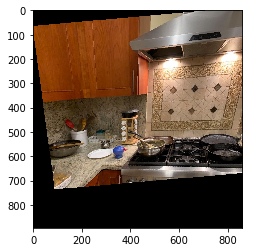

done with blending
done with saving


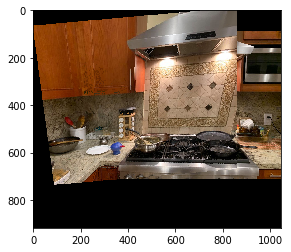

In [21]:
transf_kitchen1_pts = transform_pts(kitchen1_pts)

transf_kitchen2_pts = transform_pts(kitchen2_pts)

H_k_matrix = computeHomographies(kitchen1_pts, kitchen2_pts, kitchen2_pts.flatten().T)
print("done with homography")
kminwidth, kmaxwidth, kminheight, kmaxheight, kitchen_dummy_image = warpImage(kitchen1, kitchen2, H_k_matrix)
print("done with warping")
plt.imshow(kitchen_dummy_image)
plt.show()

blended_kitchen = blend_images(kitchen1, kitchen2, H_k_matrix, kminwidth, kmaxwidth, kminheight, kmaxheight, kitchen_dummy_image)
print("done with blending")
save_image(blended_kitchen, "blended_kitchen.jpg")
print("done with saving")
plt.imshow(blended_kitchen)
plt.show()


## PART B

### Detecting corner features in an image:

In [154]:
""" STAFF PROVIDED CODE BELOW:
"""
import numpy as np
from skimage.feature import corner_harris, peak_local_max, corner_peaks


def get_harris_corners(im, edge_discard=20, min_dist=30):
    """
    This function takes a b&w image and an optional amount to discard
    on the edge (default is 5 pixels), and finds all harris corners
    in the image. Harris corners near the edge are discarded and the
    coordinates of the remaining corners are returned. A 2d array (h)
    containing the h value of every pixel is also returned.

    h is the same shape as the original image, im.
    coords is 2 x n (ys, xs).
    """

    assert edge_discard >= 20

    # find harris corners
    h = corner_harris(im, method='eps', sigma=1)
    coords = peak_local_max(h, min_distance=min_dist, indices=True)

    # discard points on edge
    edge = edge_discard  # pixels
    mask = (coords[:, 0] > edge) & \
           (coords[:, 0] < im.shape[0] - edge) & \
           (coords[:, 1] > edge) & \
           (coords[:, 1] < im.shape[1] - edge)
    coords = coords[mask].T
    return h, coords


def dist2(x, c):
    """
    dist2  Calculates squared distance between two sets of points.

    Description
    D = DIST2(X, C) takes two matrices of vectors and calculates the
    squared Euclidean distance between them.  Both matrices must be of
    the same column dimension.  If X has M rows and N columns, and C has
    L rows and N columns, then the result has M rows and L columns.  The
    I, Jth entry is the  squared distance from the Ith row of X to the
    Jth row of C.

    Adapted from code by Christopher M Bishop and Ian T Nabney.
    """
    
    ndata, dimx = x.shape
    ncenters, dimc = c.shape
    assert(dimx == dimc, 'Data dimension does not match dimension of centers')

    return (np.ones((ncenters, 1)) * np.sum((x**2).T, axis=0)).T + \
            np.ones((   ndata, 1)) * np.sum((c**2).T, axis=0)    - \
            2 * np.inner(x, c)


In [33]:
def show_coords(coords):
    counter = 0
    xs = coords[0]
    ys = coords[1]

    for i in range(len(xs)):
        if counter > 10:
            break
        print("x: " + str(xs[i]) + ", y: " + str(ys[i]))
        counter = counter + 1


### Adaptive Non-Maximal Suppression

In [51]:
import sys, math, skimage.io as io, matplotlib.pyplot as plt, numpy as np

def dist1(x1, y1, x2, y2):
    return math.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)

def adaptive_non_maximal_suppression(h, coords, num_picked=500):
    x_points = coords[1]
    y_points = coords[0]
    c_robust = 0.9
    selected, i, j = [], 0, 0
    for i in range(len(coords[1])):
        minstrength = float("inf")
        mindist = float("inf")
        xi, yi = x_points[i], y_points[i]
        minxi, minyi = 0, 0
        for j in range(len(coords[1])):   
            xj, yj = x_points[j], y_points[j]
            if (xi != xj and yi != yj) and h[yi][xi] < c_robust * h[yj][xj]:
                curr_dist = dist1(xi, yi, xj, yj)
                if curr_dist < mindist:
                    mindist = curr_dist
                    minxi = xi
                    minyi = yi
                    minstrength = h[yi][xi]
            j += 1
        selected.append([minxi, minyi, minstrength, mindist])
        i += 1
        j = 0
    selected.sort(key=lambda x: x[3])
    selected = selected[0:num_picked]
    return selected



### Feature Descriptor extraction

In [52]:
from scipy.ndimage.interpolation import map_coordinates
from scipy.ndimage import gaussian_filter

def feature_descriptor_extract(img, selected_points, radius=8):
    all_patches = {} 
    all_patches_counter = 0
    for i in range(len(selected_points)):
        point = selected_points[i]
        x = point[0]
        y = point[1]
        strength = point[2]
        top = point[1] - 19
        bottom = point[1] + 19
        left = point[0] - 19
        right = point[0] + 19
        patch = np.zeros((40, 40), dtype=float)
        if top < 0 or bottom >= img.shape[0] or left < 0 or right >= img.shape[1]:
            break
        
        rowcounter = 0
        for row in range(top,bottom):
            colcounter = 0
            for col in range(left,right):
                patch[rowcounter][colcounter] = img[row][col]
                colcounter = colcounter + 1
            rowcounter = rowcounter + 1
        
        patch = gaussian_filter(patch, sigma=1, order=0)
        patch = np.resize(patch,(8,8))
    
        
        patch = (patch - patch.mean()) / patch.std()
        patch = np.reshape(patch, (1,64))
        all_patches[all_patches_counter] = [[point[0], point[1]]]
        all_patches[all_patches_counter].append(patch)
        all_patches_counter = all_patches_counter + 1
        
    return all_patches


### Matching these feature descriptors between two images

In [131]:
def ssd(predicted, actual):
    return np.sqrt(np.sum((predicted - actual)**2))

def contains(value, array):
    one = value[0]
    two = value[1]
    for x in array:
        if(x[0] == one and x[1] == two):
            return True 
    return False 

def feature_matching(desc1, desc2, epsilon=0.3):
    one_pairs = {}
    two_pairs = {}
    pairs_counter = 0
    for i in range(len(desc1)):
        min_dist = float("inf")
        min_point_one = []
        min_point_two = []
        second_min_dist = float("inf")
        second_min_point_one = []
        second_min_point_two = []
        
        all_dist = {}
        dist_list = []
        other_vals = {}
        counter = 0
        for j in range(len(desc2)):
            patch_one = desc1[i][1]
            patch_two = desc2[j][1]
            
            pointone = desc1[i][0]
            pointtwo = desc2[j][0]
            curr_dist = dist2(patch_one, patch_two)[0][0]
            all_dist[counter] = curr_dist
            dist_list.append(curr_dist)
            other_vals[counter] = [pointone, pointtwo, patch_one, patch_two]
            counter = counter + 1
        
        min_dist, second_min_dist = np.partition(dist_list, 1)[0:2]
        
        if(min_dist/second_min_dist < epsilon):
            to_get = -1
            for index, dist in all_dist.items(): 
                if dist == min_dist:
                    to_get = index
            one_pairs[pairs_counter] = other_vals[to_get][0]
            two_pairs[pairs_counter] = other_vals[to_get][1]
            pairs_counter = pairs_counter + 1
    return one_pairs, two_pairs


### Use a robust method (RANSAC) to compute a homography

In [142]:
import random

def ransac(pointsone, pointstwo, epsilon=1):
    best_h_matrix = []
    max_one_inlier_pts = []
    max_two_inlier_pts = []
    
    transf_one = transform_pts(pointsone)
    transf_two = transform_pts(pointstwo)
    
    for i in range(1000):
        one,two,three,four = random.sample(range(0, len(pointsone)-1), 4)
        
        ind1p1 = pointsone[one]
        ind1p2 = pointstwo[one]
        
        ind2p1 = pointsone[two]
        ind2p2 = pointstwo[two]
        
        ind3p1 = pointsone[three]
        ind3p2 = pointstwo[three]
        
        ind4p1 = pointsone[four]
        ind4p2 = pointstwo[four]
        
        source_pts = [ind1p1, ind2p1, ind3p1, ind4p1]
        dest_pts = [ind1p2, ind2p2, ind3p2, ind4p2]
        
        transf_source = transform_pts(source_pts)
        transf_dest = transform_pts(dest_pts)
        
        H_matrix = computeHomographies(source_pts, dest_pts, [])

        result = (H_matrix@transf_one.T)
        result = result.T
        predicted = divide_third(result)
        
        one_inliers = []
        two_inliers = []
        
        #print("Iteration:" + str(i))
        for j in range(len(predicted)):
            p = predicted[j]
            s = transf_one[j]
            d = transf_two[j]
            
#             print("p: ")
#             print(p)
#             print("d: ")
#             print(d)
            
            s_val = ssd(p, d)
#             print("s_val: ")
#             print(s_val)
            if s_val <  epsilon and (not contains(s, one_inliers)) and (not contains(d, two_inliers)):
#                 print("Comparing: " + str(p[0]) +", " + str(p[1]) + " and " + str(d[0]) +", " + str(d[1]))
#                 print("Sval: " + str(s_val))
                one_inliers.append(s)
                two_inliers.append(d)
#         print(len(one_inliers))
#         print(len(max_one_inlier_pts))
        if(len(one_inliers) >= len(max_one_inlier_pts)):
            #print("max one:")
#             for x in one_inliers:
#                 print(x)
#             print("max two:")
#             for x in two_inliers:
#                 print(x)
            max_one_inlier_pts = one_inliers
            max_two_inlier_pts = two_inliers
            best_h_matrix = H_matrix
    
    best_h = computeHomographies(max_one_inlier_pts, max_two_inlier_pts, [])
    
    return best_h, best_h_matrix, max_one_inlier_pts, max_two_inlier_pts

## Running autostitching on Ny Image

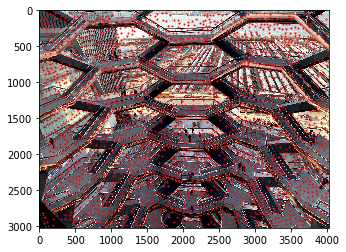

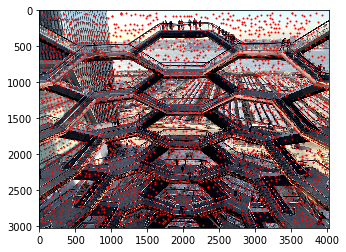

In [77]:
ny1_bw = rgb2gray(ny1)
ny3_bw = rgb2gray(ny3)


h_ny1, coords_ny1 = get_harris_corners(ny1_bw)
h_ny3, coords_ny3 = get_harris_corners(ny3_bw)

display_coords(ny1,coords_ny1)
display_coords(ny3,coords_ny3)


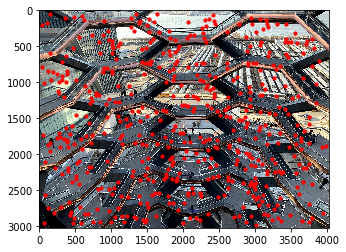

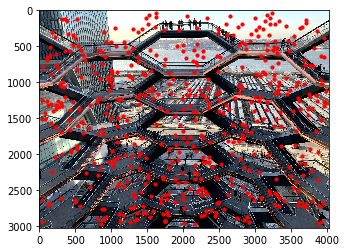

In [78]:

ny1_sorted_points = adaptive_non_maximal_suppression(h_ny1, coords_ny1)

ny3_sorted_points = adaptive_non_maximal_suppression(h_ny3, coords_ny3)

display_points(ny1, ny1_sorted_points)
display_points(ny3, ny3_sorted_points)


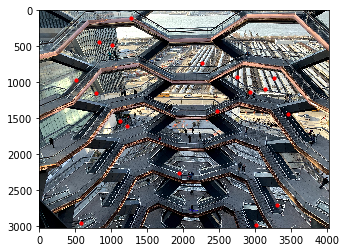

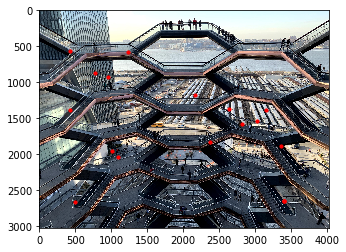

In [79]:

feat_desc_ny1 = feature_descriptor_extract(ny1_bw, ny1_sorted_points)

feat_desc_ny3 = feature_descriptor_extract(ny3_bw, ny3_sorted_points)

ny1_points, ny3_points = feature_matching(feat_desc_ny1, feat_desc_ny3)

display_points(ny1,ny1_points.values())
display_points(ny3,ny3_points.values())


In [144]:
ransac_one_ny = []
ransac_three_ny = []

for x in ny1_points.values():
    ransac_one_ny.append(x)

for x in ny3_points.values():
    ransac_three_ny.append(x)

best_h_ny, best_h_matrix_ny, max_one_inlier_pts_ny, max_two_inlier_pts_ny = ransac(ransac_one_ny,ransac_three_ny)


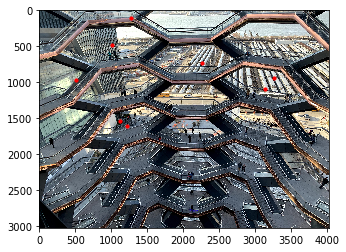

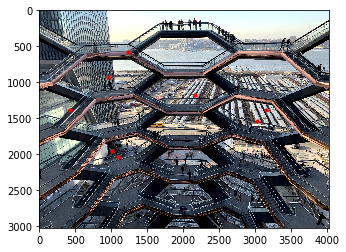

In [81]:
display_points(ny1, max_one_inlier_pts_ny)
display_points(ny3, max_two_inlier_pts_ny)


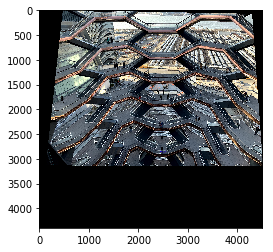

In [82]:

nyminwidth, nymaxwidth, nyminheight, nymaxheight, nyimage = warpImage(ny1, ny3, best_h_ny)

save_image(nyimage, "automatic_warped_ny.jpg")

plt.imshow(nyimage)
plt.show()

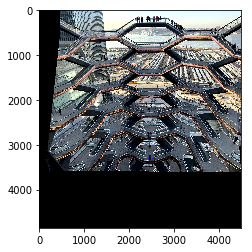

In [242]:

blended_image_ny = blend_images(ny1, ny3, best_h_ny, nyminwidth, nymaxwidth, nyminheight, nymaxheight, nyimage)

%matplotlib inline

save_image(blended_image_ny, "blended_image_ny.jpg")

plt.imshow(blended_image_ny)
plt.show()


##  Running autostitching on Kitchen Image


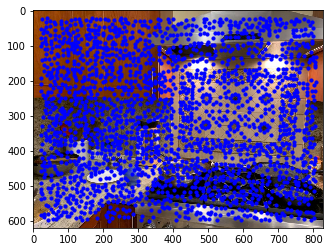

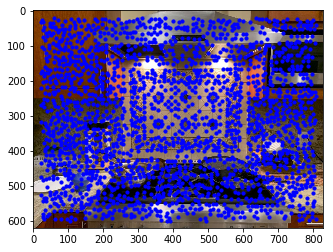

In [156]:
k1_bw = rgb2gray(kitchen1)
k2_bw = rgb2gray(kitchen2)


h_k1, coords_k1 = get_harris_corners(k1_bw, min_dist=5)
h_k2, coords_k2 = get_harris_corners(k2_bw, min_dist=5)

display_coords(kitchen1,coords_k1)
display_coords(kitchen2,coords_k2)


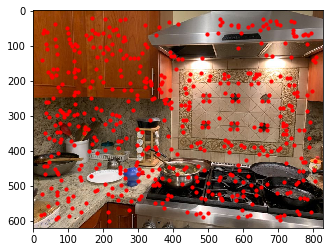

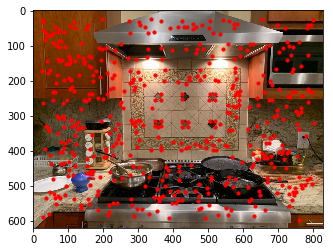

In [157]:

k1_sorted_points = adaptive_non_maximal_suppression(h_k1, coords_k1)

k2_sorted_points = adaptive_non_maximal_suppression(h_k2, coords_k2)

display_points(kitchen1, k1_sorted_points)
display_points(kitchen2, k2_sorted_points)


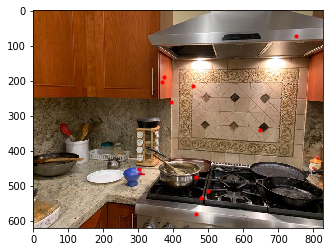

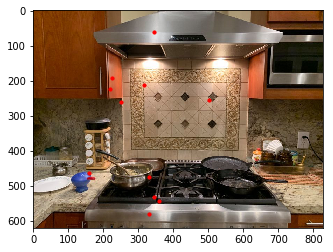

In [158]:
feat_desc_k1 = feature_descriptor_extract(k1_bw, k1_sorted_points)

feat_desc_k2 = feature_descriptor_extract(k2_bw, k2_sorted_points)

k1_points, k2_points = feature_matching(feat_desc_k1, feat_desc_k2)

display_points(kitchen1,k1_points.values())
display_points(kitchen2,k2_points.values())

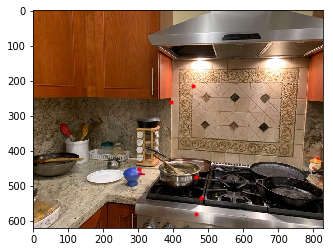

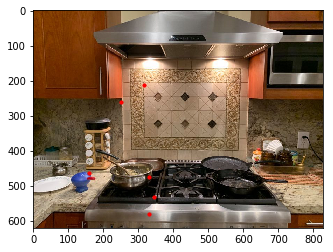

In [159]:
ransac_one_k = []
ransac_two_k = []

for x in k1_points.values():
    ransac_one_k.append(x)

for x in k2_points.values():
    ransac_two_k.append(x)

best_h_k, best_h_matrix_k, max_one_inlier_pts_k, max_two_inlier_pts_k = ransac(ransac_one_k,ransac_two_k)

display_points(kitchen1, max_one_inlier_pts_k)
display_points(kitchen2, max_two_inlier_pts_k)


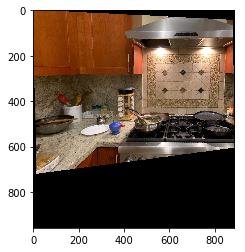

In [160]:
kminwidth, kmaxwidth, kminheight, kmaxheight, kimage = warpImage(kitchen1, kitchen2, best_h_k)

save_image(kimage, "automatic_warped_kitchen.jpg")

plt.imshow(kimage)
plt.show()



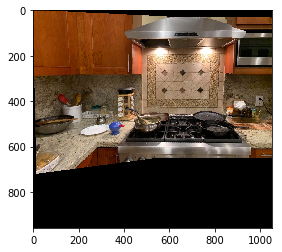

In [162]:

blended_image_kitchen = blend_images(kitchen1, kitchen2, best_h_k, kminwidth, kmaxwidth, kminheight, kmaxheight, kimage)

%matplotlib inline

save_image(blended_image_kitchen, "blended_image_kitchen.jpg")

plt.imshow(blended_image_kitchen)
plt.show()


##  Running autostitching on Bookshelf Image


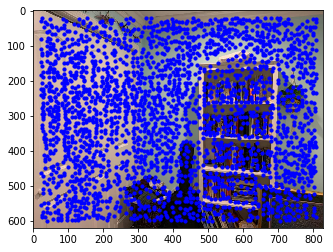

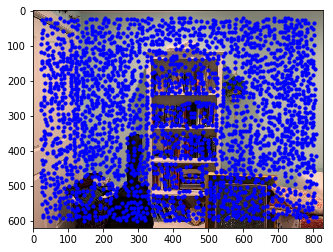

In [164]:
book1_bw = rgb2gray(book1)
book2_bw = rgb2gray(book2)


h_book1, coords_book1 = get_harris_corners(book1_bw, min_dist=5)
h_book2, coords_book2 = get_harris_corners(book2_bw, min_dist=5)

display_coords(book1,coords_book1)
display_coords(book2,coords_book2)


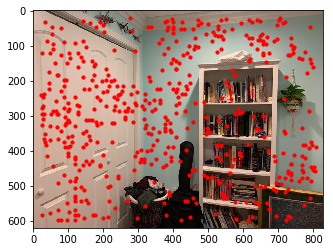

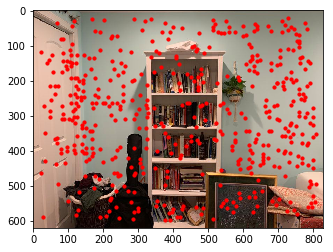

In [165]:

b1_sorted_points = adaptive_non_maximal_suppression(h_book1, coords_book1)

b2_sorted_points = adaptive_non_maximal_suppression(h_book2, coords_book2)

display_points(book1, b1_sorted_points)
display_points(book2, b2_sorted_points)


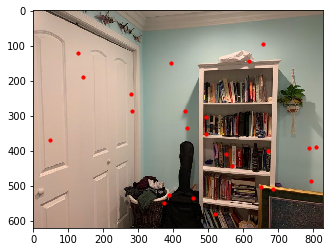

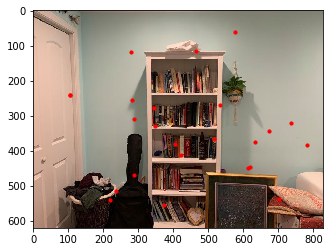

In [166]:

feat_desc_b1 = feature_descriptor_extract(book1_bw, b1_sorted_points)

feat_desc_b2 = feature_descriptor_extract(book2_bw, b2_sorted_points)

b1_points, b2_points = feature_matching(feat_desc_b1, feat_desc_b2)

display_points(book1,b1_points.values())
display_points(book2,b2_points.values())

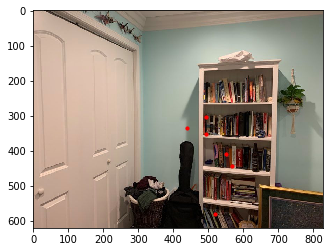

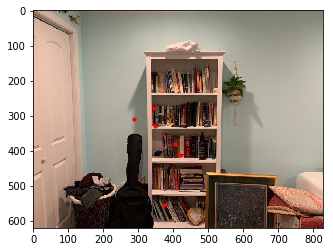

In [167]:

ransac_one_b = []
ransac_two_b = []

for x in b1_points.values():
    ransac_one_b.append(x)

for x in b2_points.values():
    ransac_two_b.append(x)

best_h_b, best_h_matrix_b, max_one_inlier_pts_b, max_two_inlier_pts_b = ransac(ransac_one_b,ransac_two_b)

display_points(book1, max_one_inlier_pts_b)
display_points(book2, max_two_inlier_pts_b)


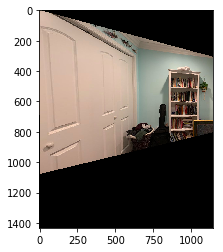

In [168]:

bminwidth, bmaxwidth, bminheight, bmaxheight, bimage = warpImage(book1, book2, best_h_b)

save_image(bimage, "automatic_warped_book.jpg")

plt.imshow(bimage)
plt.show()



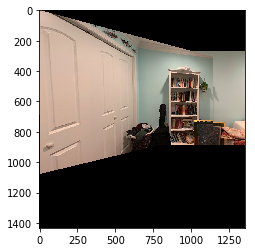

In [170]:

blended_image_book = blend_images(book1, book2, best_h_b, bminwidth, bmaxwidth, bminheight, bmaxheight, bimage)

%matplotlib inline

save_image(blended_image_book, "blended_image_book.jpg")

plt.imshow(blended_image_book)
plt.show()


##  Running autostitching on House Image


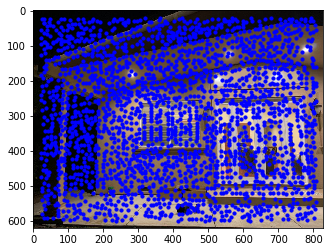

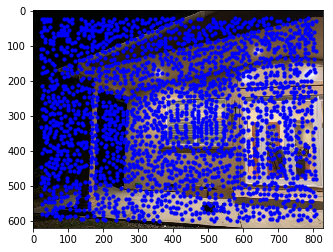

In [172]:
h1_bw = rgb2gray(house1)
h2_bw = rgb2gray(house2)

h_1, coords_h1 = get_harris_corners(h1_bw, min_dist=5)
h_2, coords_h2 = get_harris_corners(h2_bw, min_dist=5)

display_coords(house1,coords_h1)
display_coords(house2,coords_h2)


anms points:


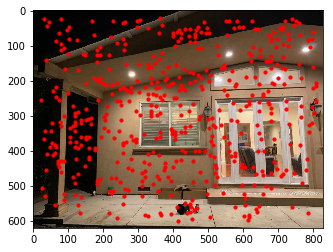

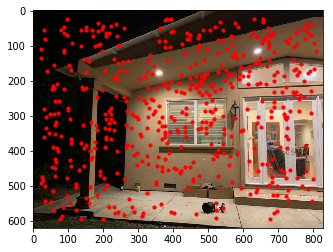

feature matching points:


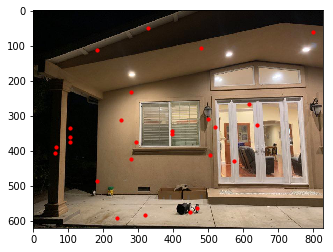

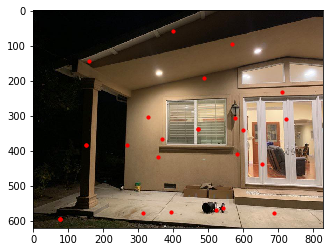

ransac points:


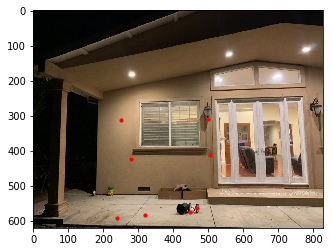

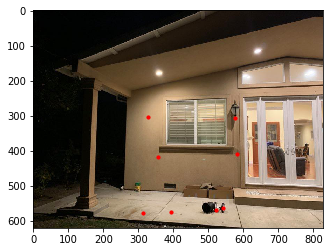

automatic warped image:


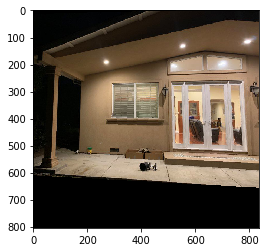

blended warped image:


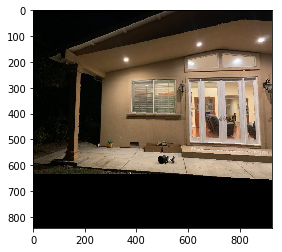

In [173]:

h1_sorted_points = adaptive_non_maximal_suppression(h_1, coords_h1)

h2_sorted_points = adaptive_non_maximal_suppression(h_1, coords_h2)

print("anms points:")
display_points(house1, h1_sorted_points)
display_points(house2, h2_sorted_points)


feat_desc_h1 = feature_descriptor_extract(h1_bw, h1_sorted_points)

feat_desc_h2 = feature_descriptor_extract(h2_bw, h2_sorted_points)

h1_points, h2_points = feature_matching(feat_desc_h1, feat_desc_h2)

print("feature matching points:")
display_points(house1,h1_points.values())
display_points(house2,h2_points.values())

ransac_one_h = []
ransac_two_h = []

for x in h1_points.values():
    ransac_one_h.append(x)

for x in h2_points.values():
    ransac_two_h.append(x)

best_h_h, best_h_matrix_h, max_one_inlier_pts_h, max_two_inlier_pts_h = ransac(ransac_one_h,ransac_two_h)

print("ransac points:")
display_points(house1, max_one_inlier_pts_h)
display_points(house2, max_two_inlier_pts_h)

hminwidth, hmaxwidth, hminheight, hmaxheight, himage = warpImage(house1, house2, best_h_h)

save_image(himage, "automatic_warped_house.jpg")

print("automatic warped image:")
plt.imshow(himage)
plt.show()

blended_image_house = blend_images(house1, house2, best_h_h, hminwidth, hmaxwidth, hminheight, hmaxheight, himage)

%matplotlib inline

save_image(blended_image_house, "blended_image_house.jpg")

print("blended warped image:")
plt.imshow(blended_image_house)
plt.show()

